# Berlin's Nightlife According to Foursquare

In this notebook I will crawl and explore [Foursquare](www.foursquare.com "foursquare.com") data for nightlife venues in Berlin. What are the most popular places to go out to? Which bars and nightclubs do people most like in Berlin?

[Thanks to [Benedikt Koehler](http://beautifuldata.net/benedikt-koehler/), this notebook is based on and inspired by his [presentation at PyData 2014, Berlin](http://pyvideo.org/video/3071/street-fighting-trend-research) on 'Street-fighting Trend Research'.]

### Access Foursquare API

To get started, we first need a access to the Foursquare API. If you don't have access tokens yet, you can register an app here and use the Client ID and the Client Secret to plug them in below. Here, I load them locally from a Pickle file in memory.

In [1]:
from cPickle import load
import foursquare
import pandas as pd
 
keys = load(file('foursquare_keys.pkl'))
CLIENT_ID = client_id=keys['client_id']
CLIENT_SECRET = keys['client_secret']
client = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

### Define Bounding Box of Berlin

We then define a location bounding box that roughly covers the areas **Mitte, Prenzlauer Berg, Friedrichshain, Kreuzberg, and Neukoelln**. To do so, we specify the north-east and south-west longitude/latitude coordinates of the bounding box. All the data we are going to mine from Foursquare will be within these geographical bounds.

However, because Foursquare limits the number of query results to 50, I will divide this bounding box to a grid of several smaller boxes, and post my queries to the Foursquare API for each of these smaller areas individually, and thereby, being able to retrieve more locations within the overall bounding box.

In [2]:
import numpy as np

# These are the geospatial coordinates of the whole Berlin area I attempt to cover
south = 52.46
west = 13.37
north = 52.55
east = 13.47

In [3]:
# Construct a grid of several small rectangular areas within the bounding box defines above
step = 100
x = np.linspace(south, north, step)
y = np.linspace(west, east, step)

bboxes = []
for i in xrange(step-1):
    for j in xrange(step-1):
        sw = '{},{}'.format(x[i], y[j])
        ne = '{},{}'.format(x[i+1], y[j+1])
        bboxes.append({'sw': sw, 'ne': ne})

### Specify Venue Categories

Next we define which [venue categories](https://developer.foursquare.com/categorytree) we want to retrieve data from. Here I chose: 

* Nightlife Spot
* Bar
* Beach Bar
* Beer Garden
* Cocktail Bar
* Dive Bar
* Karaoke Bar
* Lounge
* Nightclub
* Pub
* Sports Bar
* Whisky Bar
* Wine Bar

Each category is specified by a unique ID (see https://developer.foursquare.com/categorytree).

In [4]:
# Category IDs for Nightlife Spot, Bar, Beach Bar, Beer Garden, Cocktail Bar, Dive Bar,
# Karaoke Bar, Lounge, Nightclub, Pub, Sports Bar, Whisky Bar, and Wine Bar
categories = '4d4b7105d754a06376d81259,4bf58dd8d48988d116941735,52e81612bcbc57f1066b7a0d,' \
             '4bf58dd8d48988d117941735,4bf58dd8d48988d11e941735,4bf58dd8d48988d118941735,' \
             '4bf58dd8d48988d120941735,4bf58dd8d48988d121941735,4bf58dd8d48988d11f941735,' \
             '4bf58dd8d48988d11b941735,4bf58dd8d48988d11d941735,4bf58dd8d48988d122941735,' \
             '4bf58dd8d48988d123941735'

### Let's (Pub) Crawl!

Finally, we are ready to query Foursquare for venues that belong to one of the above categories within our Berlin bounding box grid.

In [5]:
results = []
for bbox in bboxes:
    results.append(client.venues.search(
        params={'ne': bbox['ne'], 'sw': bbox['sw'], 'limit': 50,
                'intent': 'browse', 'categoryId': categories}))

For each retrieved location, we can now store the respective entries we are interested in. For each venue, I store the following information:

- Name of the location
- Number of users
- Number of checkins
- Latitude
- Longitude
- Number of likes

In [6]:
venues = pd.DataFrame()
for res in results:
    for v in res['venues']:
        if v['id'] not in venues:
            venues = venues.append(
                pd.DataFrame({"name": v["name"], "users": v["stats"]["usersCount"],
                              "checkins": v["stats"]["checkinsCount"],
                              "lat": v["location"]["lat"],
                              "lng": v["location"]["lng"]},
                              index=[v['id']]))

### Find Links Between Venues

As a next step, I do the following: Starting at each of the locations already visited above, we go to the 5 venues that people have mostly visited after the current one (https://developer.foursquare.com/docs/venues/nextvenues) and retrieve its data. From these new location, we do the same again. In fact, we continue this recursion, until a certain depth has been reached or there are no more locations to go to.

This procedure has two purposes:

1. We find links between the venues (that we can use to build a network)
2. We might potentially find even more venues we have not visited yet before

In [ ]:
ne = '52.55,13.47'
sw = '52.46,13.37'
to_crawl = venues.index
new_crawl = []
links = []
done = []
depth = 10
for i in xrange(depth):
    new_crawl = []
    for vi in to_crawl:
        # Get next locations
        next_venues = client.venues.nextvenues(vi)
        for nv in next_venues['nextVenues']['items']:
            # Check if it is a nightlife spot
            cats = [cat['id'] for cat in nv['categories']]
            if set(cats).intersection(set(categories.split(','))):
                # Check if it is within the bounding box
                if ((nv["location"]["lat"] > float(sw.split(',')[0])) &
                    (nv["location"]["lat"] < float(ne.split(',')[0])) & 
                    (nv["location"]["lng"] > float(sw.split(',')[1])) &
                    (nv["location"]["lng"] < float(ne.split(',')[1]))):
                    if nv['id'] not in venues:
                        # Retrieve the data if not visited before
                        venues = venues.append(
                            pd.DataFrame(
                                {"name": nv["name"], "users": nv["stats"]["usersCount"],
                                 "checkins": nv["stats"]["checkinsCount"],
                                 "lat": nv["location"]["lat"], "lng": nv["location"]["lng"],
                                 "likes": client.venues.likes(nv['id'])['likes']['count']},
                                index=[nv['id']]))
                    if ((nv["id"] not in done) & (nv["id"] not in to_crawl) &
                        (nv["id"] not in new_crawl)):
                        new_crawl.append(nv["id"])
                    links.append((vi, nv["id"]))
        done.append(vi)
    to_crawl = new_crawl

### Remove Duplicates, Get Number of Likes

**Nice!** Next will retrieve the number of **likes** from the API, add this as a column to the DataFrame and also remove potential duplicate locations in the DataFrame.

In [8]:
venues = venues.reset_index().drop_duplicates(cols='index',take_last=True).set_index('index')
venues['likes'] = [client.venues.likes(v)['likes']['count'] for v in venues.index]

**Let's have a look** at the first 5 entries in our DataFrame:

In [9]:
venues.head()

checkins        lat  likes        lng  \
index                                                             
4d63c8dca45b54818d72052d        22  52.460217      0  13.381255   
4ed215b7490168f8d1d880fb         0  52.460513      0  13.429897   
51b1d495498e66da98752370        21  52.460751      1  13.435045   
4ea063c0775ba9493a85b323         5  52.460964      0  13.371723   
520fde0511d2ecadc23f3435        24  52.461053      1  13.442867   

                                       name  users  
index                                               
4d63c8dca45b54818d72052d      Blumenthaleck     14  
4ed215b7490168f8d1d880fb       Germania-Eck      0  
51b1d495498e66da98752370       beim stecher      2  
4ea063c0775ba9493a85b323  Kaiser Augusta 39      2  
520fde0511d2ecadc23f3435     Dufte Musikbar      9

### Build a Directed Graph

**Awesome, moving on.** We are going to use Python's `netwworkx` library in order to construct a directed graph from our data.

In [10]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(venues.index)
for f,t in links:
    G.add_edge(f, t)
print nx.info(G)

Name: 
Type: DiGraph
Number of nodes: 2902
Number of edges: 621
Average in degree:   0.2140
Average out degree:   0.2140


### Compute Graph Metics: Degree Centrality, Betweenness Centrality, PageRank

We see that the graph consists of 2902 nightlife locations and 621 edges between them.

Using this graph we are able to compute a few interesting network analysis metrics. Here I compute **degree centrality**, **betweenness centrality** and **pagerank**.

- The degree centrality for a specific node is the fraction of nodes it is connected to.
- Betweenness centrality "is an indicator of a node's centrality in a network. It is equal to the number of shortest paths from all vertices to all others that pass through that node" (http://en.wikipedia.org/wiki/Betweenness_centrality).
- Pagerank (originally designed as an algorithm to rank web pages), "computes a ranking of the nodes in the graph based on the structure of the incoming links". 

In [11]:
pagerank = nx.pagerank(G)
betweenness = nx.betweenness_centrality(G)
centrality = nx.degree_centrality(G)
venues['pagerank'] = pd.Series(pagerank, index=venues.index)
venues['betweenness'] = pd.Series(betweenness, index=venues.index)
venues['centrality'] = pd.Series(centrality, index=venues.index)

### Data Overview

Ok, let's have anther look at the first entries of the DataFrame again now that we have added some columns. We see that it now contains our new metrics.

In [12]:
venues.head()

checkins        lat  likes        lng  \
index                                                             
4d63c8dca45b54818d72052d        22  52.460217      0  13.381255   
4ed215b7490168f8d1d880fb         0  52.460513      0  13.429897   
51b1d495498e66da98752370        21  52.460751      1  13.435045   
4ea063c0775ba9493a85b323         5  52.460964      0  13.371723   
520fde0511d2ecadc23f3435        24  52.461053      1  13.442867   

                                       name  users  pagerank  betweenness  \
index                                                                       
4d63c8dca45b54818d72052d      Blumenthaleck     14  0.000238            0   
4ed215b7490168f8d1d880fb       Germania-Eck      0  0.000238            0   
51b1d495498e66da98752370       beim stecher      2  0.000238            0   
4ea063c0775ba9493a85b323  Kaiser Augusta 39      2  0.000238            0   
520fde0511d2ecadc23f3435     Dufte Musikbar      9  0.000238            0   

                          centrality  
index                                 
4d63c8dca45b54818d72052d           0  
4ed215b7490168f8d1d880fb           0  
51b1d495498e66da98752370           0  
4ea063c0775ba9493a85b323           0  
520fde0511d2ecadc23f3435           0

We can also display some summary statistics of our database:

In [13]:
venues.describe()

checkins          lat        likes          lng        users     pagerank  betweenness   centrality
count   2902.000000  2902.000000  2902.000000  2902.000000  2902.000000  2902.000000  2902.000000  2902.000000
mean     232.376292    52.510983     8.856995    13.420534   135.467953     0.000345     0.000001     0.000148
std      603.235397     0.020424    27.895281     0.024370   352.293466     0.000878     0.000007     0.000632
min        0.000000    52.460217     0.000000    13.370069     0.000000     0.000238     0.000000     0.000000
25%        3.000000    52.495837     0.000000    13.402036     2.000000     0.000238     0.000000     0.000000
50%       18.000000    52.511121     0.000000    13.420664     8.000000     0.000238     0.000000     0.000000
75%      158.000000    52.528140     5.000000    13.437825    90.750000     0.000238     0.000000     0.000000
max    11017.000000    52.555000   638.000000    13.475352  5007.000000     0.025317     0.000192     0.010686

### Let's Plot the Top Locations!

In [14]:
%pylab inline
import matplotlib.pyplot as plt
def plot_top_locations(venues, column, n=20, ax=None):
    venues.sort(column, inplace=True)
    venues.set_index('name')[-n:][column].plot(kind='barh', color='r', alpha=0.5, fontsize=15)
    ax.set_ylabel('')
    ax.set_title('Top {} locations by {}'.format(n, column), fontsize=20);

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


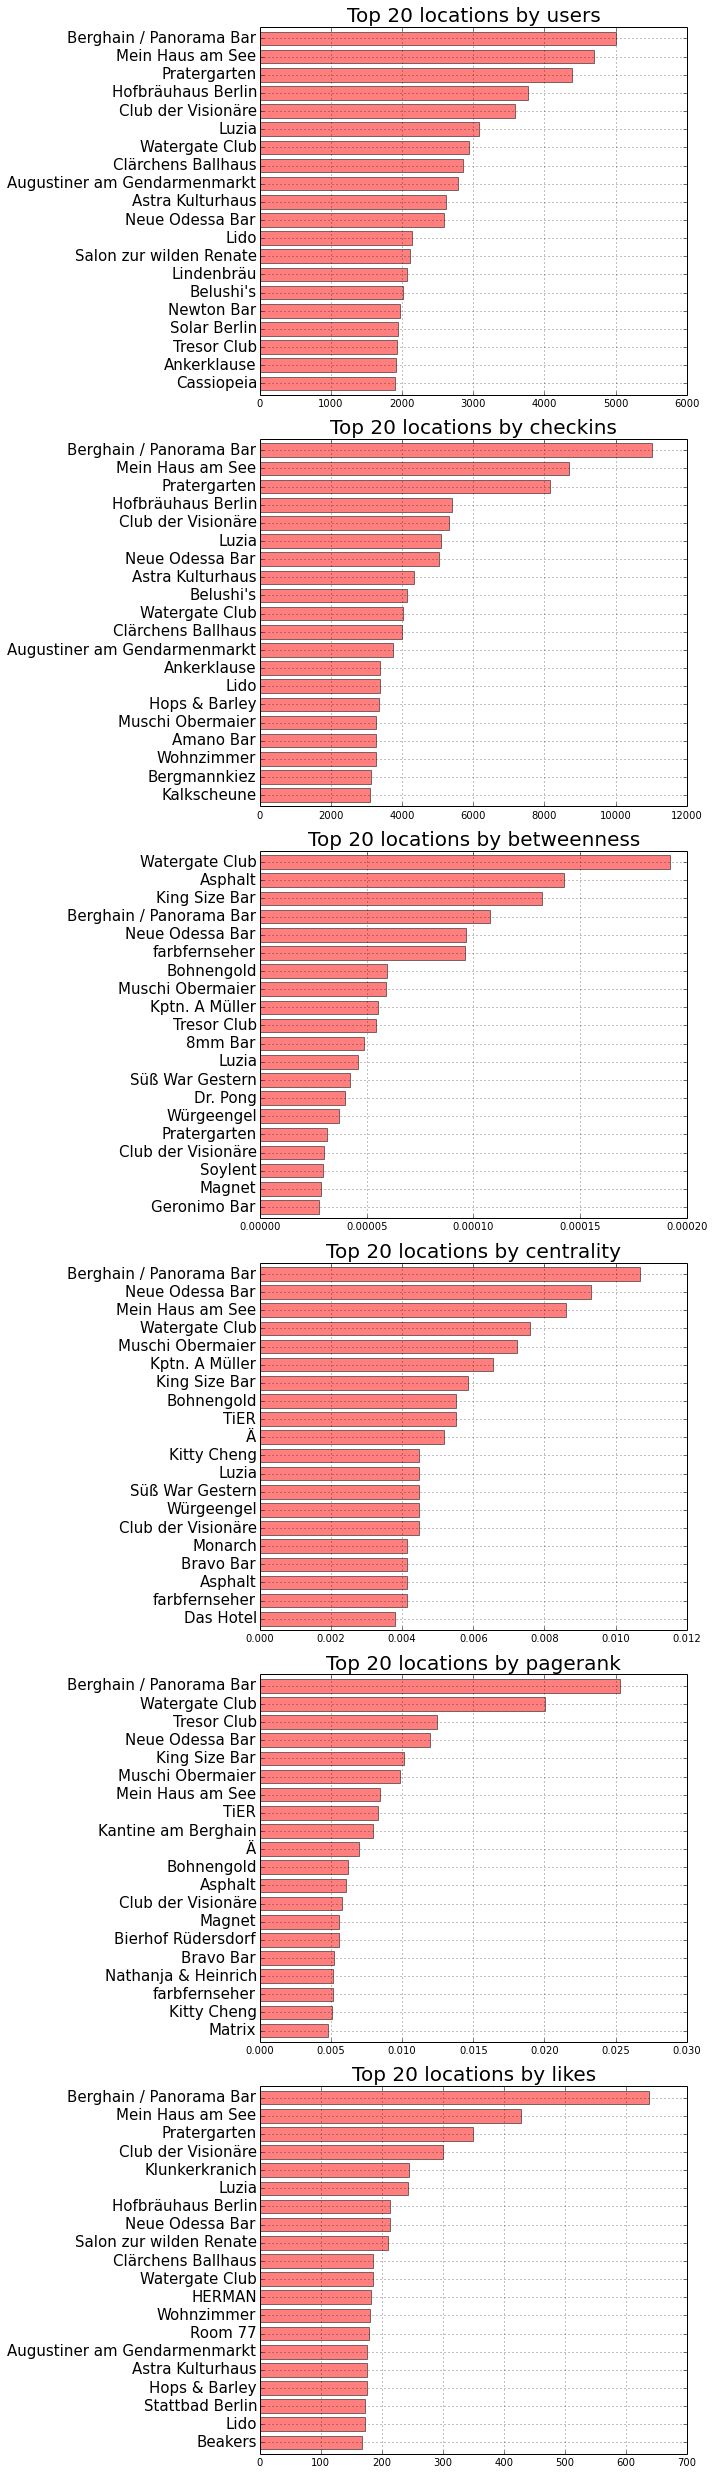

In [15]:
columns_to_plot = ['users', 'checkins', 'betweenness', 'centrality', 'pagerank', 'likes']
fig = plt.figure(figsize=(10, 40), dpi=150)
for i in xrange(len(columns_to_plot)):
    ax = fig.add_subplot(7, 1, i+1)
    plot_top_locations(venues, columns_to_plot[i], 20, ax)
plt.tight_layout()

### Wordcloud

Now, let's visualize the data with a wordcloud. Therefor, I am using Andreas Mueller's Python [implementation](https://github.com/amueller/word_cloud) of a wordcloud. As metric for the size of each plotted word, I am going to use the number of users at each location.

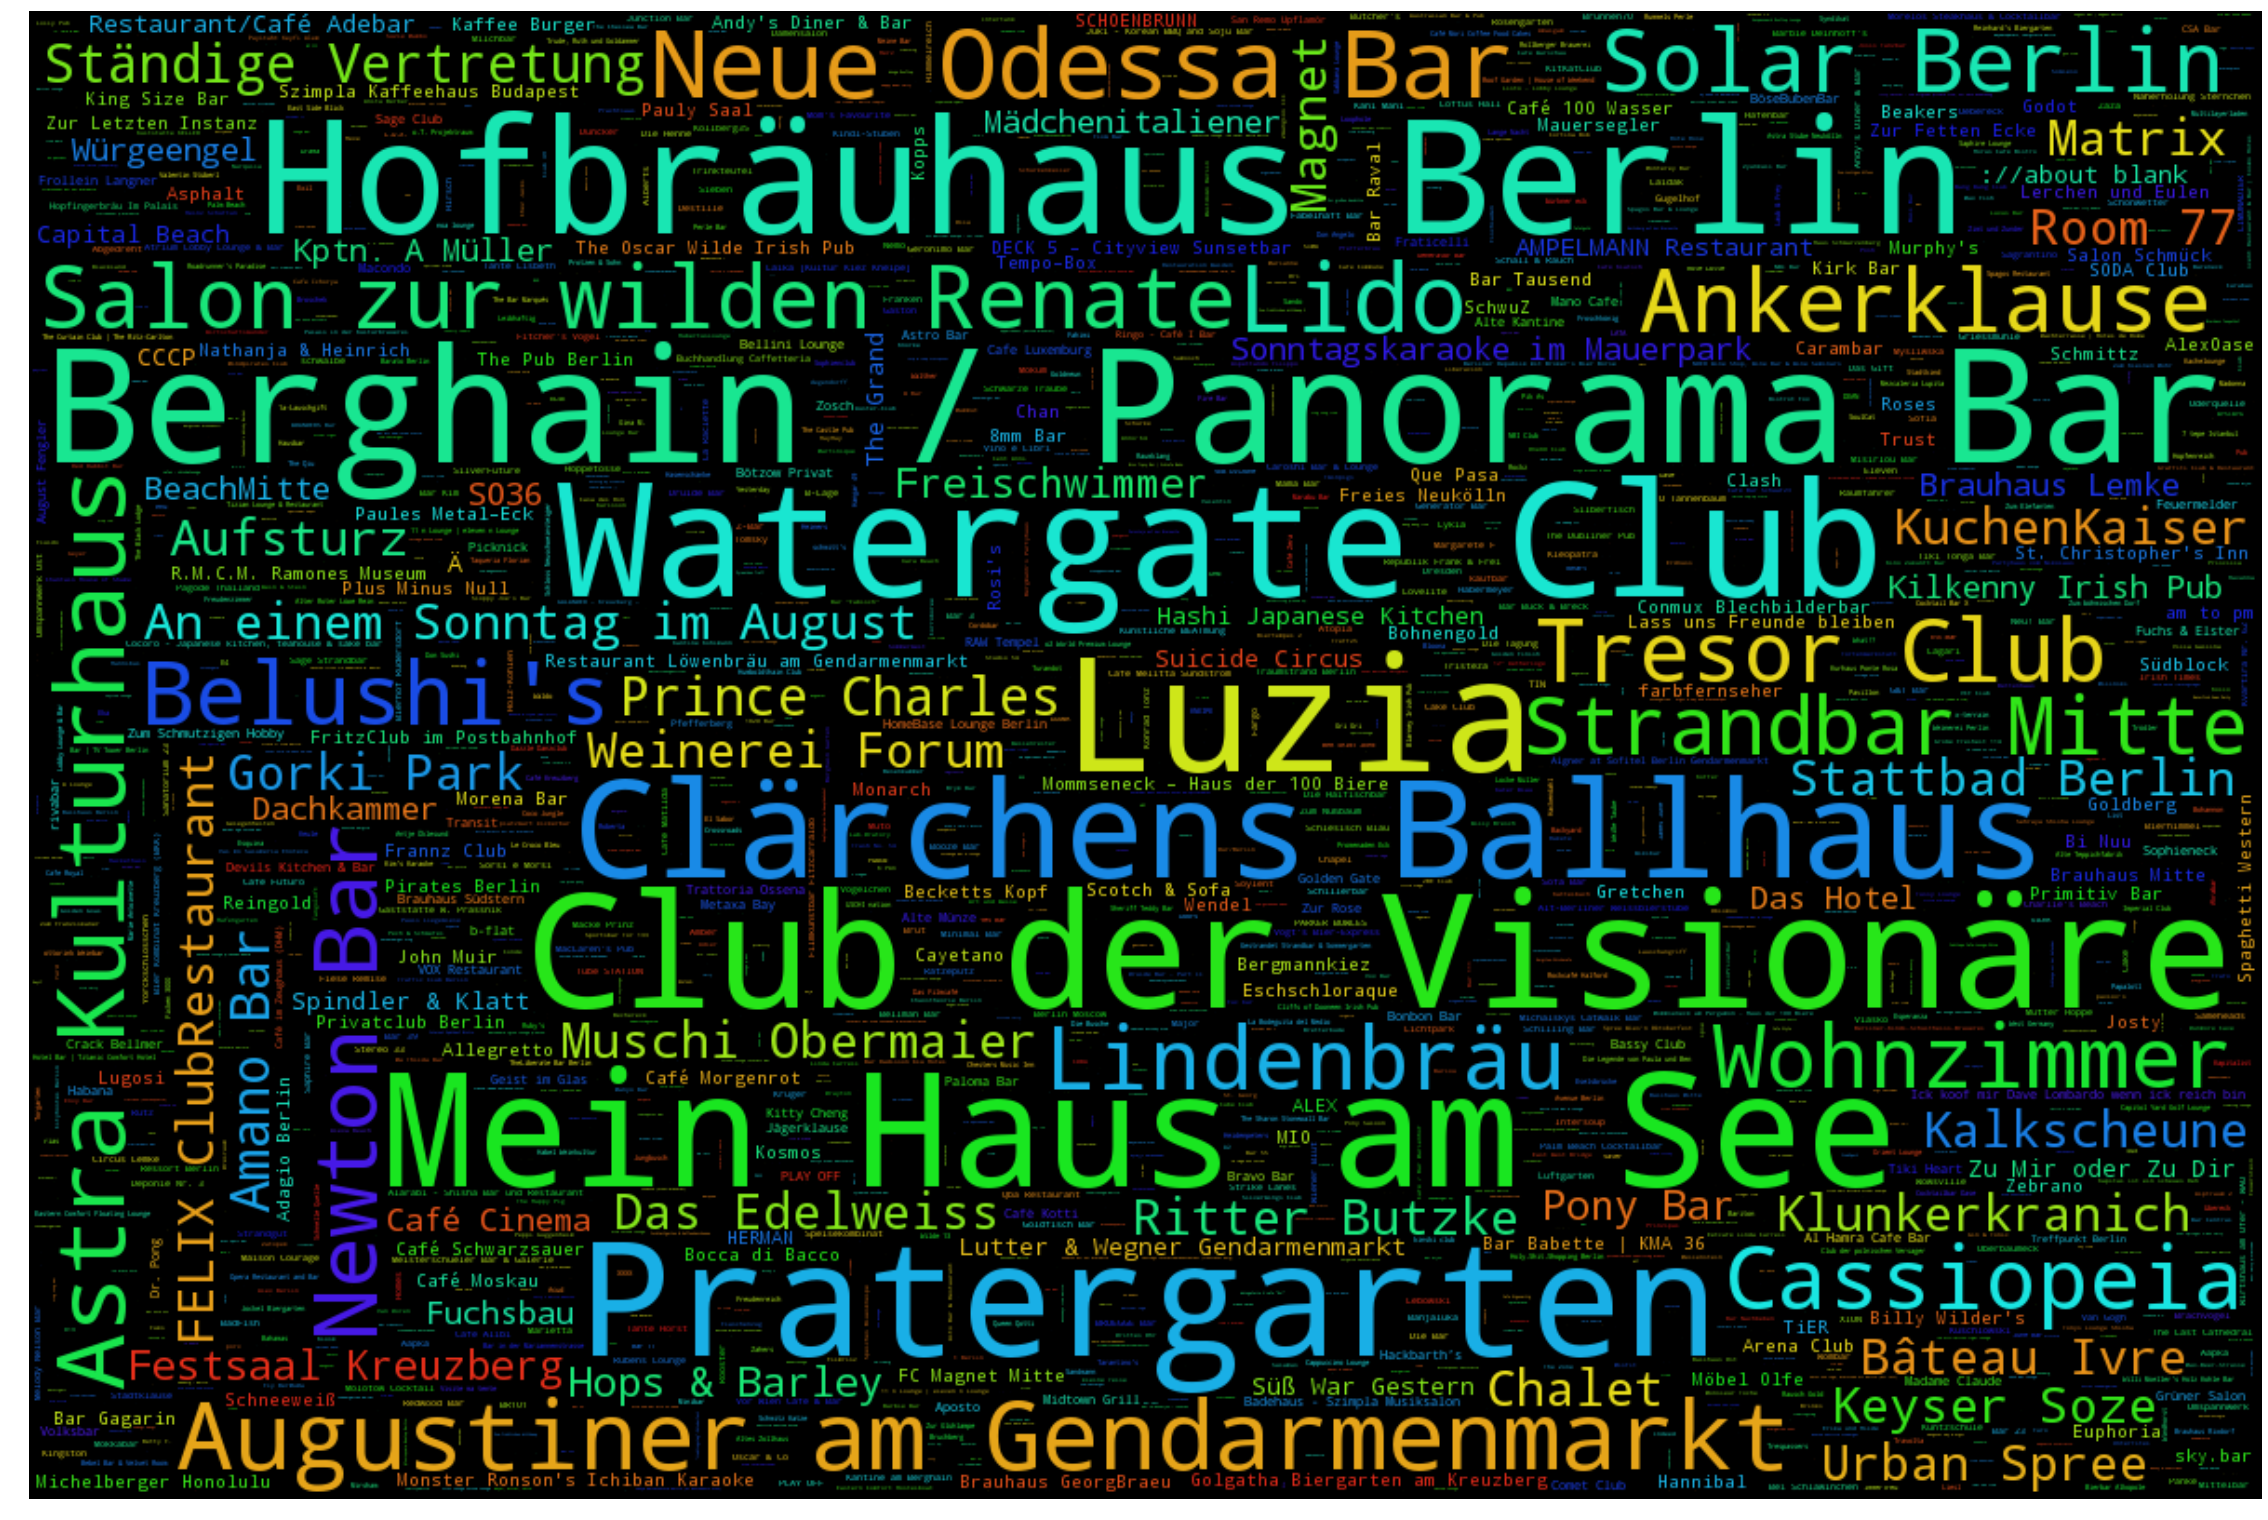

In [16]:
import wordcloud
metric = 'users'
word_list = []
sorted_venues = venues.sort('users', ascending=False)
for v in sorted_venues.index:
    word_list.append((venues.ix[v]['name'], venues.ix[v]['users']))

elems = wordcloud.fit_words(
    word_list, width=1200, height=800, margin=5, ranks_only=False, prefer_horiz=0.90)
wordcloud.draw(elems, 'wordcloud_{}.png'.format(metric), width=1200, height=800)

import Image
im = Image.open('wordcloud_{}.png'.format(metric))
plt.figure(figsize=(40, 40), dpi=300)
plt.imshow(im)
plt.axis('off');

## Network Visualization

We can also visualize the whole network. The size of the nodes are displayed according to the pagerank value of the corresponding location. Because we have too many nodes in our graph to visualize properly, I am going to visualize the network only for the top 100 venues (according to pagerank).

Name: 
Type: DiGraph
Number of nodes: 100
Number of edges: 230
Average in degree:   2.3000
Average out degree:   2.3000


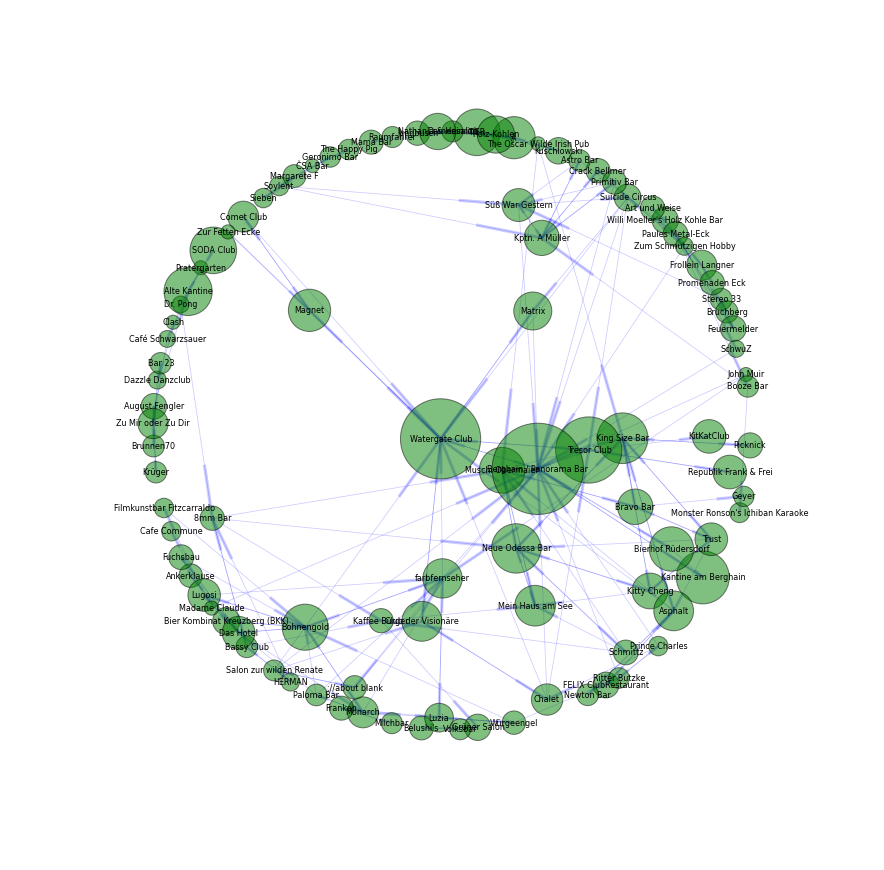

In [17]:
topvenues = venues.sort('pagerank', ascending=False)[:100]

import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(topvenues.index)
for f,t in links:
    if f in G.nodes() and t in G.nodes():
        G.add_edge(f, t)
print nx.info(G)

pagerank = nx.pagerank(G)
betweenness = nx.betweenness_centrality(G)
centrality = nx.degree_centrality(G)
topvenues['pagerank'] = pd.Series(pagerank, index=topvenues.index)

%matplotlib inline
import matplotlib.pyplot as plt
labels = topvenues["name"].to_dict()
fig = plt.figure(figsize=(15, 15), dpi=150)
graph_pos = nx.spring_layout(G, k=0.1, iterations=100)
nodesize = dict()
for k, v in topvenues.pagerank.iteritems():
    nodesize[k] = v * 100000
for n in G.nodes():
    nx.draw_networkx_nodes(
        G, graph_pos, nodelist=[n], node_size=nodesize[n], alpha=0.5, node_color='green')
nx.draw_networkx_edges(G, graph_pos, width=0.8, alpha=0.2, edge_color='blue')
nx.draw_networkx_labels(G, graph_pos, labels=labels, font_size=8)
plt.axis('off');

### Plot Data on OpenStreetMap

We can also nicely plot our location data on a [OpenStreetMap](http://www.openstreetmap.com) basemap. To do so, we first need to rescale the geodata to fit our basemap:

$\LARGE x_{new} = {{x - min(x)} \over {max(x) - min(x)}}$

In [21]:
venues['x'] = 2224 * (venues.lng - 13.3508) / (13.4823 - 13.3508)
venues['y'] = 1748 - 1748 * (venues.lat - 52.4708) / (52.5337 - 52.4708)
venues = venues[(venues.x >= 0) & (venues.y >= 0)]

Here, I plot the top 50 locations and label them.

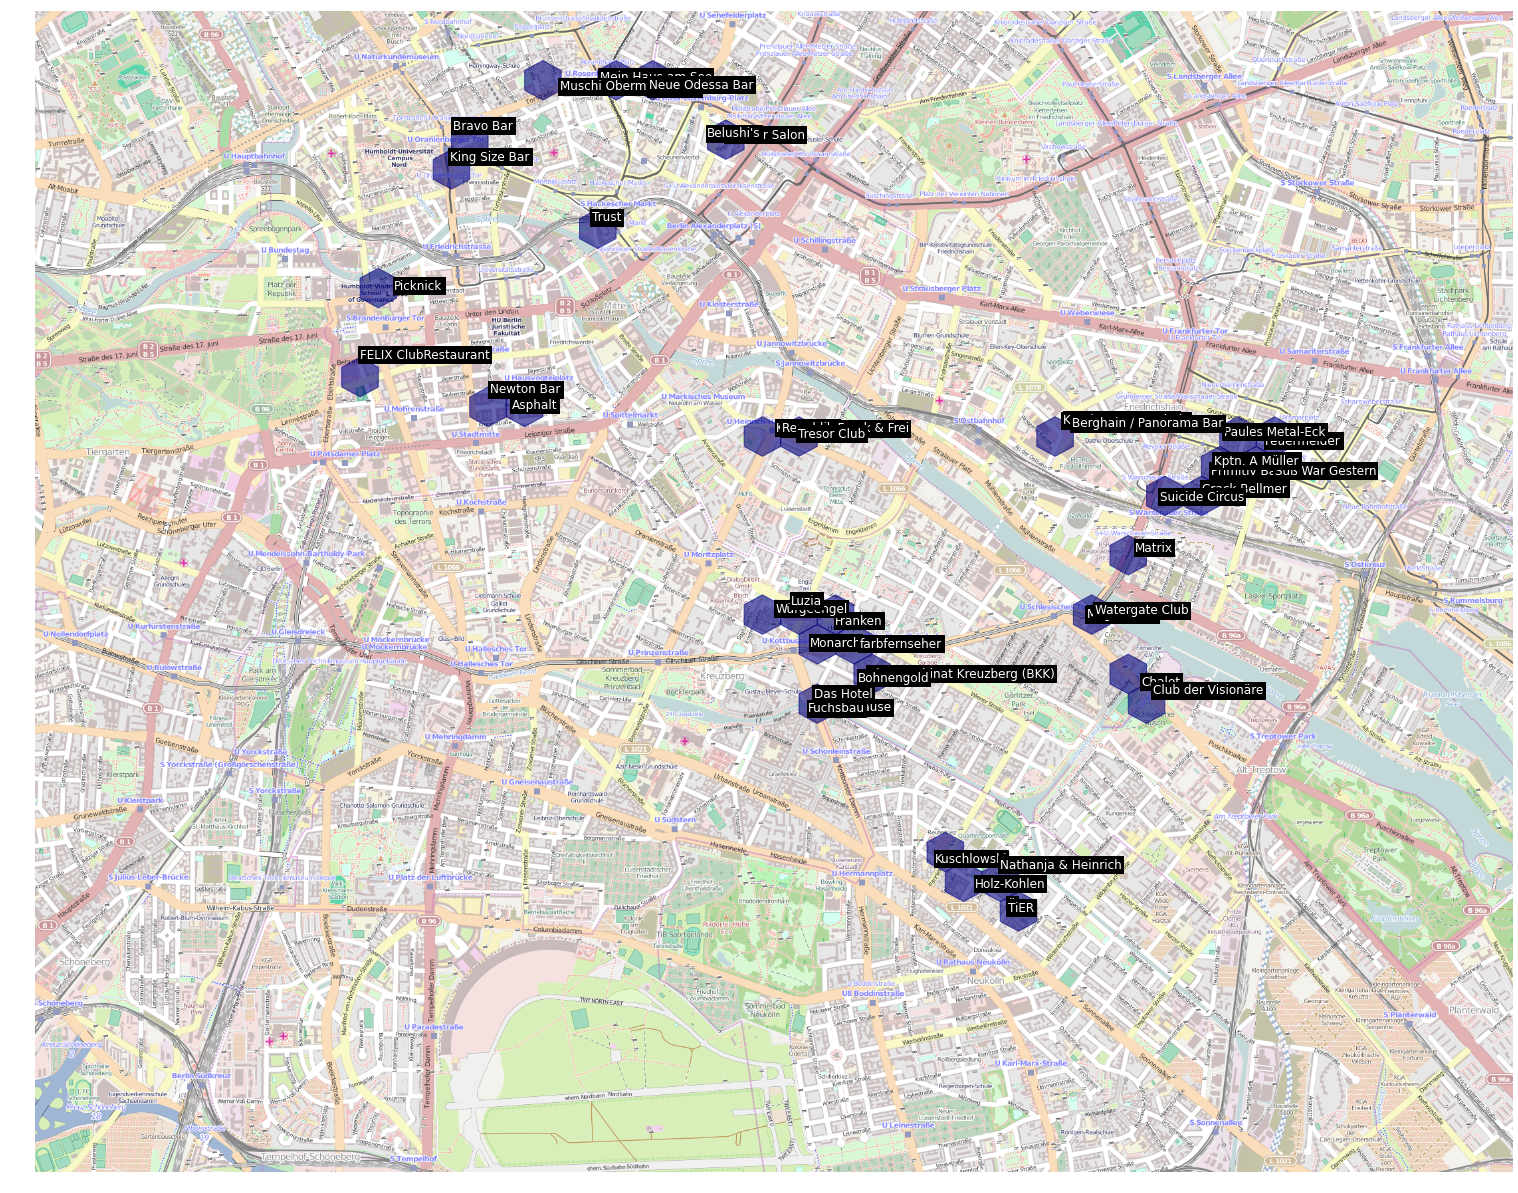

In [24]:
tops = venues.sort('pagerank', ascending=False)[:50][::-1]
figure(figsize=(29.54, 20.8)) 
img = imread("map2.png")
plt.imshow(img, zorder=0, alpha=0.8)
plt.hexbin(tops['x'], tops['y'], gridsize=25, C=venues.pagerank,
           reduce_C_function=np.mean, zorder=1, alpha=0.6)
plt.axis('off')
cb.set_label('Pagerank', fontsize=18)
for i in tops.index:
    plt.text(venues.ix[i]['x'], venues.ix[i]['y'], venues.ix[i]['name'],
             backgroundcolor='k', color='w', fontsize=12)